In [249]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from dask.diagnostics import ProgressBar
from sklearn.linear_model import ElasticNet
import numpy as np
from scipy.stats import linregress
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ARDRegression
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# Exploration of DataScience Methods to create Energy Forecasts
1. Site-specific linear regression, extracting site-specific energy forecasts using Linear Approaches
2. Spatial linear regression using EOFS and Linear Approaches
3. Deep Neural Networks and Convolutional Neural Networks

In [252]:
df = pd.read_excel(r"C:\Users\rampaln\Downloads\daily-gen-201706-202105.xlsx", index_col=0,
                   parse_dates=True,
                   sheet_name='daily-gen-201706-202105')
reanalysis = xr.open_dataset(r'C:\Users\rampaln\Documents\rpreprocess_u_v_w_t2m_msl_on_nz_grid.nc')

In [215]:
df

,tarwf3,tarwfb,tarwfl,teapi1,terer1,teuku1,white1,westw1,Unnamed: 9,westw2,westw3
dd/mm/yyyy,,,,,,,,,,,
2017-06-01,514513.0,96624.0,134147,201958.0,139727.0,106557.0,NaN,450192,NaN,220095.0,230097.0
2017-06-02,777948.0,182806.0,225599,483106.0,230193.0,902202.0,NaN,558451,NaN,286756.0,271695.0
2017-06-03,510014.0,159165.0,192554,170417.0,152201.0,652590.0,110445.0,417616,NaN,183909.0,233707.0
2017-06-04,165433.0,25655.0,38911,37084.0,23299.0,44002.0,54055.0,825341,NaN,336555.0,488786.0
2017-06-05,532296.0,78385.0,110415,244280.0,121874.0,166662.0,90125.0,1560523,NaN,765285.0,795238.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,296507.0,33939.0,57647,125454.0,45239.0,124927.0,474900.0,864399,NaN,425480.0,438919.0
2021-05-28,247439.0,45935.0,62988,170107.0,32897.0,217965.0,31895.0,1686743,NaN,823656.0,863087.0
2021-05-29,739616.0,183583.0,229849,627724.0,239162.0,553926.0,325811.0,841050,NaN,364059.0,476991.0


# Data Notes:
1. df: Power provided by Richard
2. df: Renalysis data at 0.5 degrees (t2m, msl, u, v)
3. Defined two indepedent periods to validate the data over

In [253]:
df.index.name ='time'
keyname = 'tarwfl'
df = df.apply(lambda a: np.sqrt(a))
df = df.to_xarray()[keyname]
common = df.dropna("time").time.to_index().intersection(reanalysis.time.to_index())

df = df.sel(time = common)

df = df.to_dataset()

reanalysis = reanalysis.sel(time = common)
reanalysis = (reanalysis - reanalysis.mean())/reanalysis.std()

df = (df - df.mean())/df.std()


## Reformat the Data to a desired format
1. Identify common times associated with the data
2. UTC time is assumed (not necccessaerily true)

Text(0.5, 0.98, 'Correlation of tarwfl with Surrounding Observations for all time (daily)')

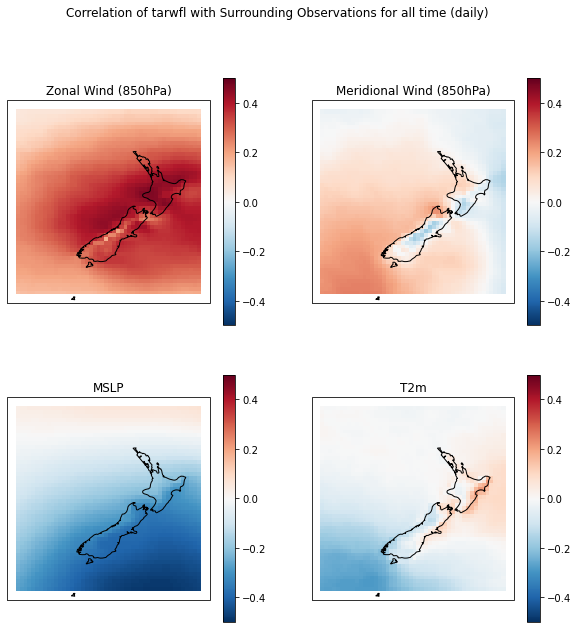

In [254]:
corr_u = xr.corr(reanalysis['u'], df[keyname], dim ="time")
corr_v = xr.corr(reanalysis['v'], df[keyname], dim ="time")
corr_msl = xr.corr(reanalysis['msl'], df[keyname], dim ="time")
corr_t2m = xr.corr(reanalysis['t2m'], df[keyname], dim ="time")
variables =[corr_u, corr_v,corr_msl, corr_t2m]
names = ['Zonal Wind (850hPa)', 'Meridional Wind (850hPa)','MSLP','T2m']
import cartopy.crs as ccrs
fig, ax = plt.subplots(2,2, subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude = 171.77)),
                      figsize = (10,10))
ax = ax.ravel()
for i, axes in enumerate(ax):
    variables[i].plot(ax = axes, transform = ccrs.PlateCarree(), vmin = -0.5, vmax = 0.5, cmap ='RdBu_r')
    axes.coastlines('50m')
    axes.set_title(names[i])
fig.suptitle(f'Correlation of {keyname} with Surrounding Observations for all time (daily)')

# Creating Error Metrics for a forecast

In [230]:
corrcoef = lambda a,b: np.corrcoef(a,b)[0,1]
rmse = lambda a,b: np.sqrt(np.nanmean(abs(a-b)**2))
bias = lambda a,b: np.nanmean(a-b)
mae = lambda a,b: np.nanmean(abs(a-b))
n_train = 1000

# number of observations used to train

# Correlate all site specific Obserations (48 * 48 * 4)
1. Determine the region with strongest correlation - train a variety of site specific models
2. define error metrics for this baseline

# Models 
1. KNN

In [276]:
cls = KNeighborsRegressor(5)
# selection of model
def fit_regressor(x1, x2, x3, x4, y1):
    X = np.vstack([x1, x2, x3,x4]).T
    x_train = X[0:n_train]
    y_train = y1[0:n_train]
    cls.fit(x_train, y_train)
    predict = cls.predict(X[n_train:])

    return corrcoef(predict.ravel(),y1[1000:].ravel()), rmse(predict.ravel(),y1[1000:].ravel()), mae(predict.ravel(),y1[1000:].ravel())

with ProgressBar():
    reanalysis = reanalysis.chunk({"latitude":48,"longitude":48})
    corrcoefs, rmses, maes = xr.apply_ufunc(fit_regressor, reanalysis['u'],
                                reanalysis['v'], reanalysis['t2m'],
                                reanalysis['msl'],df[keyname],
                                input_core_dims=[["time"],["time"],["time"],
                                                 ["time"],["time"]],
                                output_core_dims=[[],[],[]],
                                vectorize=True,
                                dask='parallelized',
                                output_dtypes=[np.float,np.float, np.float])#.compute()
    corrcoefs = corrcoefs.compute()
    rmses = rmses.compute()
    maes =maes.compute()
    lat_, lon_ = np.where(corrcoefs == corrcoefs.max(
        ))




[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.5s


<ipython-input-270-93ff38a8a38b>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


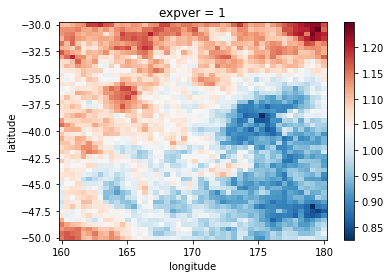

In [270]:
fig, ax = plt.subplots()
rmses.plot(ax = ax,cmap ='RdBu_r')
fig.show()

# Find Location with Maximum Correlation


In [271]:
rmses[lat_,lon_].values.ravel()[0]


0.8261022609989799

In [277]:
metrics = pd.DataFrame()
metrics.loc['KNN_Site','rmse'] = rmses[lat_,lon_].values.ravel()[0]
metrics.loc['KNN_Site','mae'] = maes[lat_,lon_].values.ravel()[0]
metrics.loc['KNN_Site','corrcoef'] = corrcoefs[lat_,lon_].values.ravel()[0]

In [273]:
metrics

,rmse,mae,corrcoef
KNN_Site,0.826102,0.66916,0.609642


In [278]:
cls = Ridge()
# selection of model
def fit_regressor(x1, x2, x3, x4, y1):
    X = np.vstack([x1, x2, x3,x4]).T
    x_train = X[0:n_train]
    y_train = y1[0:n_train]
    cls.fit(x_train, y_train)
    predict = cls.predict(X[n_train:])

    return corrcoef(predict.ravel(),y1[1000:].ravel()), rmse(predict.ravel(),y1[1000:].ravel()), mae(predict.ravel(),y1[1000:].ravel())

with ProgressBar():
    reanalysis = reanalysis.chunk({"latitude":48,"longitude":48})
    corrcoefs, rmses, maes = xr.apply_ufunc(fit_regressor, reanalysis['u'],
                                reanalysis['v'], reanalysis['t2m'],
                                reanalysis['msl'],df[keyname],
                                input_core_dims=[["time"],["time"],["time"],
                                                 ["time"],["time"]],
                                output_core_dims=[[],[],[]],
                                vectorize=True,
                                dask='parallelized',
                                output_dtypes=[np.float,np.float, np.float])#.compute()
    corrcoefs = corrcoefs.compute()
    rmses = rmses.compute()
    maes =maes.compute()
    lat_, lon_ = np.where(corrcoefs == corrcoefs.max(
        ))

metrics.loc['Ridge_Site','rmse'] = rmses[lat_,lon_].values.ravel()[0]
metrics.loc['Ridge_Site','mae'] = maes[lat_,lon_].values.ravel()[0]
metrics.loc['Ridge_Site','corrcoef'] = corrcoefs[lat_,lon_].values.ravel()[0]


[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.8s


In [279]:

metrics.loc['Ridge_Site','rmse'] = rmses[lat_,lon_].values.ravel()[0]
metrics.loc['Ridge_Site','mae'] = maes[lat_,lon_].values.ravel()[0]
metrics.loc['Ridge_Site','corrcoef'] = corrcoefs[lat_,lon_].values.ravel()[0]

In [283]:
import sklearn
cls = sklearn.linear_model.LinearRegression()
cls = RandomForestRegressor(n_estimators =10, max_depth =10)
# selection of model
def fit_regressor(x1, x2, x3, x4, y1):
    X = np.vstack([x1, x2, x3,x4]).T
    x_train = X[0:n_train]
    y_train = y1[0:n_train]
    cls.fit(x_train, y_train)
    predict = cls.predict(X[n_train:])

    return corrcoef(predict.ravel(),y1[1000:].ravel()), rmse(predict.ravel(),y1[1000:].ravel()), mae(predict.ravel(),y1[1000:].ravel())

with ProgressBar():
    reanalysis = reanalysis.chunk({"latitude":48,"longitude":48})
    corrcoefs, rmses, maes = xr.apply_ufunc(fit_regressor, reanalysis['u'],
                                reanalysis['v'], reanalysis['t2m'],
                                reanalysis['msl'],df[keyname],
                                input_core_dims=[["time"],["time"],["time"],
                                                 ["time"],["time"]],
                                output_core_dims=[[],[],[]],
                                vectorize=True,
                                dask='parallelized',
                                output_dtypes=[np.float,np.float, np.float])#.compute()
    corrcoefs = corrcoefs.compute()
    rmses = rmses.compute()
    maes =maes.compute()
    lat_, lon_ = np.where(corrcoefs == corrcoefs.max(
        ))

metrics.loc['Linear_Site','rmse'] = rmses[lat_,lon_].values.ravel()[0]
metrics.loc['Linear_Site','mae'] = maes[lat_,lon_].values.ravel()[0]
metrics.loc['Linear_Site','corrcoef'] = corrcoefs[lat_,lon_].values.ravel()[0]


[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.2s


In [285]:
cls = RandomForestRegressor(n_estimators =10, max_depth =10)
# selection of model
def fit_regressor(x1, x2, x3, x4, y1):
    X = np.vstack([x1, x2, x3,x4]).T
    x_train = X[0:n_train]
    y_train = y1[0:n_train]
    cls.fit(x_train, y_train)
    predict = cls.predict(X[n_train:])

    return corrcoef(predict.ravel(),y1[1000:].ravel()), rmse(predict.ravel(),y1[1000:].ravel()), mae(predict.ravel(),y1[1000:].ravel())

with ProgressBar():
    reanalysis = reanalysis.chunk({"latitude":48,"longitude":48})
    corrcoefs, rmses, maes = xr.apply_ufunc(fit_regressor, reanalysis['u'],
                                reanalysis['v'], reanalysis['t2m'],
                                reanalysis['msl'],df[keyname],
                                input_core_dims=[["time"],["time"],["time"],
                                                 ["time"],["time"]],
                                output_core_dims=[[],[],[]],
                                vectorize=True,
                                dask='parallelized',
                                output_dtypes=[np.float,np.float, np.float])#.compute()
    corrcoefs = corrcoefs.compute()
    rmses = rmses.compute()
    maes =maes.compute()
    lat_, lon_ = np.where(corrcoefs == corrcoefs.max(
        ))

metrics.loc['RandomForest_Site','rmse'] = rmses[lat_,lon_].values.ravel()[0]
metrics.loc['RandomForest_Site','mae'] = maes[lat_,lon_].values.ravel()[0]
metrics.loc['RandomForest_Site','corrcoef'] = corrcoefs[lat_,lon_].values.ravel()[0]

[########################################] | 100% Completed | 57.3s
[########################################] | 100% Completed | 59.4s
[########################################] | 100% Completed | 58.0s


In [287]:
metrics

,rmse,mae,corrcoef
KNN_Site,0.826102,0.669160,0.609642
Ridge_Site,0.886773,0.750623,0.515455
ElasticNet_Site,1.017235,0.871730,0.487596
Linear_Site,0.886763,0.750605,0.515466
RandomForest_Site,0.812037,0.661841,0.624714


# Principal Component Analysis + Simple ML Techniques
1. Enable the model to use the spatial patterns to represent these prediction of fields

## Prepare the Data

In [290]:
reanalysis_train = reanalysis.isel(time = slice(0, 1000))
reanalysis_test = reanalysis.isel(time = slice( 1000, None))
data = df[keyname]
#data = (data - data.min())/(data.max() - data.min())
y_train = data.isel(time = slice(0, 1000))
y_test = data.isel(time = slice( 1000, None))

def concat(reanalysis):
    features = xr.concat([reanalysis['u'],reanalysis['v'],
           reanalysis['t2m'],
                      reanalysis['msl']],
                     dim ="channel").transpose("time","latitude",
                                               "longitude","channel")
    return features
x_train = concat(reanalysis_train)
x_test = concat(reanalysis_test)


# Data Processing.
1. Normalize each Pixel value all fields (msl, t2m, u, v) for all 48 * 48 pixels
2. Reduce the dimensionality with PCA
3. Apply a prediction model

In [295]:
pipeline = Pipeline((('sc', StandardScaler()),
                     ('pca', PCA(n_components = 32, whiten = True)),
                     ('rf',RandomForestRegressor(n_estimators =80,  max_depth =35))))
pipeline.fit(x_train.stack(z =["latitude","longitude","channel"]).values, y_train)
preds = pipeline.predict(x_test.stack(z =["latitude","longitude","channel"]).values)
metrics.loc['RandomForest_Spatial','rmse'] = rmse(preds,y_test.values.ravel())
metrics.loc['RandomForest_Spatial','mae'] = mae(preds,y_test.values.ravel())
metrics.loc['RandomForest_Spatial','corrcoef'] = corrcoef(preds,y_test.values.ravel())

In [296]:
metrics

,rmse,mae,corrcoef
KNN_Site,0.826102,0.669160,0.609642
Ridge_Site,0.886773,0.750623,0.515455
ElasticNet_Site,1.017235,0.871730,0.487596
Linear_Site,0.886763,0.750605,0.515466
RandomForest_Site,0.812037,0.661841,0.624714
RandomForest_Spatial,0.799738,0.671825,0.667176


In [303]:
pipeline = Pipeline((('sc', StandardScaler()),
                     ('pca', PCA(n_components = 32, whiten = True)),
                     ('rf',Ridge())))
pipeline.fit(x_train.stack(z =["latitude","longitude","channel"]).values, y_train)
preds = pipeline.predict(x_test.stack(z =["latitude","longitude","channel"]).values)
metrics.loc['Ridge_Spatial','rmse'] = rmse(preds,y_test.values.ravel())
metrics.loc['Ridge_Spatial','mae'] = mae(preds,y_test.values.ravel())
metrics.loc['Ridge_Spatial','corrcoef'] = corrcoef(preds,y_test.values.ravel())

C:\Users\rampaln\Anaconda3\envs\ml_ops\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\rampaln\Anaconda3\envs\ml_ops\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [304]:
metrics

,rmse,mae,corrcoef
KNN_Site,0.826102,0.669160,0.609642
Ridge_Site,0.886773,0.750623,0.515455
ElasticNet_Site,1.017235,0.871730,0.487596
Linear_Site,0.886763,0.750605,0.515466
RandomForest_Site,0.812037,0.661841,0.624714
RandomForest_Spatial,0.799738,0.671825,0.667176
Ridge_Spatial,0.818978,0.660991,0.612354


In [305]:
pipeline = Pipeline((('sc', StandardScaler()),
                     ('pca', PCA(n_components =32, whiten = True)),
                     ('rf',KNeighborsRegressor(5))))
pipeline.fit(x_train.stack(z =["latitude","longitude","channel"]).values, y_train)
preds = pipeline.predict(x_test.stack(z =["latitude","longitude","channel"]).values)
metrics.loc['KNN_Spatial','rmse'] = rmse(preds,y_test.values.ravel())
metrics.loc['KNN_Spatial','mae'] = mae(preds,y_test.values.ravel())
metrics.loc['KNN_Spatial','corrcoef'] = corrcoef(preds,y_test.values.ravel())

In [306]:
metrics

,rmse,mae,corrcoef
KNN_Site,0.826102,0.669160,0.609642
Ridge_Site,0.886773,0.750623,0.515455
ElasticNet_Site,1.017235,0.871730,0.487596
Linear_Site,0.886763,0.750605,0.515466
RandomForest_Site,0.812037,0.661841,0.624714
RandomForest_Spatial,0.799738,0.671825,0.667176
Ridge_Spatial,0.818978,0.660991,0.612354
KNN_Spatial,0.828269,0.653490,0.605819


In [307]:
pipeline = Pipeline((('sc', StandardScaler()),
                     ('pca', PCA(n_components =32, whiten = True)),
                     ('rf',ARDRegression())))
pipeline.fit(x_train.stack(z =["latitude","longitude","channel"]).values, y_train)
preds = pipeline.predict(x_test.stack(z =["latitude","longitude","channel"]).values)
metrics.loc['ARD_Spatial','rmse'] = rmse(preds,y_test.values.ravel())
metrics.loc['ARD_Spatial','mae'] = mae(preds,y_test.values.ravel())
metrics.loc['ARD_Spatial','corrcoef'] = corrcoef(preds,y_test.values.ravel())

In [309]:
pipeline = Pipeline((('sc', StandardScaler()),
                     ('pca', PCA(n_components =32, whiten = True)),
                     ('rf',sklearn.linear_model.LinearRegression())))
pipeline.fit(x_train.stack(z =["latitude","longitude","channel"]).values, y_train)
preds = pipeline.predict(x_test.stack(z =["latitude","longitude","channel"]).values)
metrics.loc['Linear_Spatial','rmse'] = rmse(preds,y_test.values.ravel())
metrics.loc['Linear_Spatial','mae'] = mae(preds,y_test.values.ravel())
metrics.loc['Linear_Spatial','corrcoef'] = corrcoef(preds,y_test.values.ravel())

In [310]:
metrics

,rmse,mae,corrcoef
KNN_Site,0.826102,0.669160,0.609642
Ridge_Site,0.886773,0.750623,0.515455
ElasticNet_Site,1.017235,0.871730,0.487596
Linear_Site,0.886763,0.750605,0.515466
RandomForest_Site,0.812037,0.661841,0.624714
RandomForest_Spatial,0.799738,0.671825,0.667176
Ridge_Spatial,0.818978,0.660991,0.612354
KNN_Spatial,0.828269,0.653490,0.605819
ARD_Spatial,0.817796,0.666348,0.613440
Linear_Spatial,0.818911,0.660776,0.612449


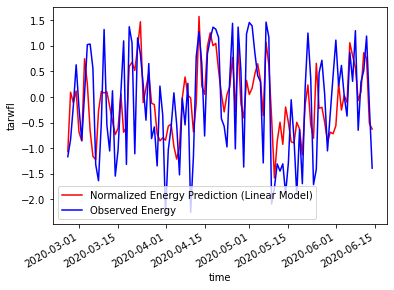

In [312]:
preds = pipeline.predict(x_test.stack(z =["latitude","longitude","channel"]).values)
preds1 = y_test.copy()
preds1.values = preds.ravel()
fig, ax = plt.subplots()
preds1.plot(ax = ax, color ='r', label ='Normalized Energy Prediction (Linear Model)')
y_test.plot(ax = ax, color='b', label ='Observed Energy')
ax.legend()

# Deep Learning Models

In [316]:




import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D,\
    Dense, BatchNormalization, MaxPool2D, Flatten, Dropout
inputs = Input(shape = (48,48,4))

flatten = Flatten()(inputs)
drops = Dropout(0.7)(flatten)
dense1 = Dense(512, activation='linear')(drops)
dense1 = Dense(32, activation='linear')(dense1)
output = Dense(1, activation ='linear')(dense1)
model = tf.keras.models.Model(inputs, output)
model.compile(loss ='mse', optimizer ='adam')


history =model.fit(x_train.values, y_train.values,
          validation_data=(x_test.values, y_test.values),
          batch_size=80, epochs =80, use_multiprocessing=True, verbose =2)
preds = model.predict(x_test)
metrics.loc['VanillaNN_Spatial','rmse'] = rmse(preds.ravel(),y_test.values.ravel())
metrics.loc['VanillaNN_Spatial','mae'] = mae(preds.ravel(),y_test.values.ravel())
metrics.loc['VanillaNN_Spatial','corrcoef'] = corrcoef(preds.ravel(),y_test.values.ravel())
metrics

Epoch 1/80
13/13 - 1s - loss: 882.7418 - val_loss: 478.8119
Epoch 2/80
13/13 - 0s - loss: 123.5871 - val_loss: 4.5426
Epoch 3/80
13/13 - 0s - loss: 20.4259 - val_loss: 5.9659
Epoch 4/80
13/13 - 0s - loss: 7.4160 - val_loss: 1.4718
Epoch 5/80
13/13 - 0s - loss: 2.8685 - val_loss: 1.0311
Epoch 6/80
13/13 - 0s - loss: 2.0558 - val_loss: 0.8104
Epoch 7/80
13/13 - 0s - loss: 1.6391 - val_loss: 0.7506
Epoch 8/80
13/13 - 0s - loss: 1.4341 - val_loss: 0.6792
Epoch 9/80
13/13 - 0s - loss: 1.4094 - val_loss: 0.6803
Epoch 10/80
13/13 - 0s - loss: 1.4634 - val_loss: 0.6773
Epoch 11/80
13/13 - 0s - loss: 1.3949 - val_loss: 0.6717
Epoch 12/80
13/13 - 0s - loss: 1.3258 - val_loss: 0.8110
Epoch 13/80
13/13 - 0s - loss: 1.2628 - val_loss: 0.6913
Epoch 14/80
13/13 - 0s - loss: 1.1595 - val_loss: 0.7020
Epoch 15/80
13/13 - 0s - loss: 1.1554 - val_loss: 0.6940
Epoch 16/80
13/13 - 0s - loss: 1.0973 - val_loss: 0.6767
Epoch 17/80
13/13 - 0s - loss: 1.0930 - val_loss: 0.7036
Epoch 18/80
13/13 - 0s - loss: 1.

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 110

In [319]:
metrics

,rmse,mae,corrcoef
KNN_Site,0.826102,0.669160,0.609642
Ridge_Site,0.886773,0.750623,0.515455
ElasticNet_Site,1.017235,0.871730,0.487596
Linear_Site,0.886763,0.750605,0.515466
RandomForest_Site,0.812037,0.661841,0.624714
RandomForest_Spatial,0.799738,0.671825,0.667176
Ridge_Spatial,0.818978,0.660991,0.612354
KNN_Spatial,0.828269,0.653490,0.605819
ARD_Spatial,0.817796,0.666348,0.613440
Linear_Spatial,0.818911,0.660776,0.612449


# Simple Convolutional Neural Network

In [321]:




import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D,\
    Dense, BatchNormalization, MaxPool2D, Flatten, Dropout
inputs = Input(shape = (48,48,4))
conv1 = Conv2D(kernel_size=5, activation='relu', filters =16)(inputs)
pool = MaxPool2D(2)(conv1)
flatten = Flatten()(pool)
drops = Dropout(0.3)(flatten)
dense1 = Dense(64, activation='linear')(drops)
output = Dense(1, activation ='linear')(dense1)
model = tf.keras.models.Model(inputs, output)
model.compile(loss ='mse', optimizer ='adam')


model.fit(x_train.values, y_train.values,
          validation_data=(x_test.values, y_test.values),
          batch_size=80, epochs =80, verbose =2, use_multiprocessing=True)
preds = model.predict(x_test)
metrics.loc['SimpleCNN_Spatial','rmse'] = rmse(preds.ravel(),y_test.values.ravel())
metrics.loc['SimpleCNN_Spatial','mae'] = mae(preds.ravel(),y_test.values.ravel())
metrics.loc['SimpleCNN_Spatial','corrcoef'] = corrcoef(preds.ravel(),y_test.values.ravel())
metrics

Epoch 1/80
13/13 - 1s - loss: 32.5364 - val_loss: 3.7505
Epoch 2/80
13/13 - 0s - loss: 4.4248 - val_loss: 1.8496
Epoch 3/80
13/13 - 0s - loss: 1.8236 - val_loss: 0.9342
Epoch 4/80
13/13 - 0s - loss: 0.9915 - val_loss: 0.7802
Epoch 5/80
13/13 - 0s - loss: 0.7511 - val_loss: 0.7436
Epoch 6/80
13/13 - 0s - loss: 0.6465 - val_loss: 0.7376
Epoch 7/80
13/13 - 0s - loss: 0.6165 - val_loss: 0.6955
Epoch 8/80
13/13 - 0s - loss: 0.5748 - val_loss: 0.6972
Epoch 9/80
13/13 - 0s - loss: 0.5309 - val_loss: 0.6884
Epoch 10/80
13/13 - 0s - loss: 0.5376 - val_loss: 0.6839
Epoch 11/80
13/13 - 0s - loss: 0.5143 - val_loss: 0.6360
Epoch 12/80
13/13 - 0s - loss: 0.4935 - val_loss: 0.6775
Epoch 13/80
13/13 - 0s - loss: 0.4787 - val_loss: 0.6253
Epoch 14/80
13/13 - 0s - loss: 0.4683 - val_loss: 0.6006
Epoch 15/80
13/13 - 0s - loss: 0.4699 - val_loss: 0.5993
Epoch 16/80
13/13 - 0s - loss: 0.4235 - val_loss: 0.5989
Epoch 17/80
13/13 - 0s - loss: 0.4290 - val_loss: 0.6084
Epoch 18/80
13/13 - 0s - loss: 0.3987 -

,rmse,mae,corrcoef
KNN_Site,0.826102,0.669160,0.609642
Ridge_Site,0.886773,0.750623,0.515455
ElasticNet_Site,1.017235,0.871730,0.487596
Linear_Site,0.886763,0.750605,0.515466
RandomForest_Site,0.812037,0.661841,0.624714
RandomForest_Spatial,0.799738,0.671825,0.667176
Ridge_Spatial,0.818978,0.660991,0.612354
KNN_Spatial,0.828269,0.653490,0.605819
ARD_Spatial,0.817796,0.666348,0.613440
Linear_Spatial,0.818911,0.660776,0.612449


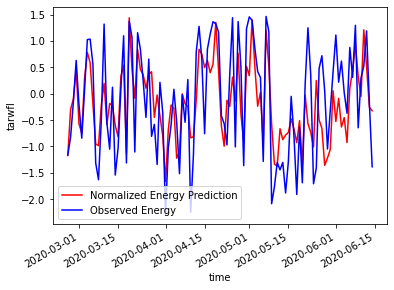

In [322]:
preds = model.predict(x_test)
preds1 = y_test.copy()
preds1.values = preds.ravel()
fig, ax = plt.subplots()
preds1.plot(ax = ax, color ='r', label ='Normalized Energy Prediction')
y_test.plot(ax = ax, color='b', label ='Observed Energy')
ax.legend()

# Deep CNN

In [327]:




import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D,\
    Dense, BatchNormalization, MaxPool2D, Flatten, Dropout
input = Input(shape = (48,48,4))
conv1 = Conv2D(kernel_size=5, activation='relu', filters =16)(input)
pool = MaxPool2D(2)(conv1)
conv1 = Conv2D(kernel_size=5, activation='relu', filters =32)(pool)
pool = MaxPool2D(2)(conv1)
conv1 = Conv2D(kernel_size=5, activation='relu', filters =64)(pool)
pool = MaxPool2D(2)(conv1)
flatten = Flatten()(pool)
drops = Dropout(0.7)(flatten)
dense1 = Dense(64, activation='linear')(drops)
output = Dense(1, activation ='linear')(dense1)
model = tf.keras.models.Model(input, output)
model.compile(loss ='mse', optimizer ='adam')


def concat(reanalysis):
    features = xr.concat([reanalysis['u'],reanalysis['v'],
           reanalysis['t2m'],
                      reanalysis['msl']],
                     dim ="channel").transpose("time","latitude",
                                               "longitude","channel")
    return features
model.fit(x_train.values, y_train.values,
          validation_data=(x_test.values, y_test.values),
          batch_size=80, epochs =80, use_multiprocessing=True, verbose =2)
preds = model.predict(x_test)
metrics.loc['DeepCNN_Spatial','rmse'] = rmse(preds.ravel(),y_test.values.ravel())
metrics.loc['DeepCNN_Spatial','mae'] = mae(preds.ravel(),y_test.values.ravel())
metrics.loc['DeepCNN_Spatial','corrcoef'] = corrcoef(preds.ravel(),y_test.values.ravel())
metrics

Epoch 1/80
13/13 - 2s - loss: 1.0282 - val_loss: 0.8514
Epoch 2/80
13/13 - 1s - loss: 0.7698 - val_loss: 0.8170
Epoch 3/80
13/13 - 1s - loss: 0.7148 - val_loss: 0.7681
Epoch 4/80
13/13 - 1s - loss: 0.6503 - val_loss: 0.7401
Epoch 5/80
13/13 - 1s - loss: 0.6431 - val_loss: 0.7208
Epoch 6/80
13/13 - 1s - loss: 0.6126 - val_loss: 0.7149
Epoch 7/80
13/13 - 1s - loss: 0.6021 - val_loss: 0.6742
Epoch 8/80
13/13 - 1s - loss: 0.5955 - val_loss: 0.6732
Epoch 9/80
13/13 - 1s - loss: 0.5386 - val_loss: 0.6409
Epoch 10/80
13/13 - 1s - loss: 0.5578 - val_loss: 0.6746
Epoch 11/80
13/13 - 1s - loss: 0.5349 - val_loss: 0.6449
Epoch 12/80
13/13 - 1s - loss: 0.5237 - val_loss: 0.6363
Epoch 13/80
13/13 - 1s - loss: 0.4972 - val_loss: 0.6828
Epoch 14/80
13/13 - 1s - loss: 0.4990 - val_loss: 0.6294
Epoch 15/80
13/13 - 1s - loss: 0.4875 - val_loss: 0.6390
Epoch 16/80
13/13 - 1s - loss: 0.4987 - val_loss: 0.6037
Epoch 17/80
13/13 - 1s - loss: 0.4799 - val_loss: 0.6580
Epoch 18/80
13/13 - 1s - loss: 0.4745 - 

,rmse,mae,corrcoef
KNN_Site,0.826102,0.669160,0.609642
Ridge_Site,0.886773,0.750623,0.515455
ElasticNet_Site,1.017235,0.871730,0.487596
Linear_Site,0.886763,0.750605,0.515466
RandomForest_Site,0.812037,0.661841,0.624714
RandomForest_Spatial,0.799738,0.671825,0.667176
Ridge_Spatial,0.818978,0.660991,0.612354
KNN_Spatial,0.828269,0.653490,0.605819
ARD_Spatial,0.817796,0.666348,0.613440
Linear_Spatial,0.818911,0.660776,0.612449


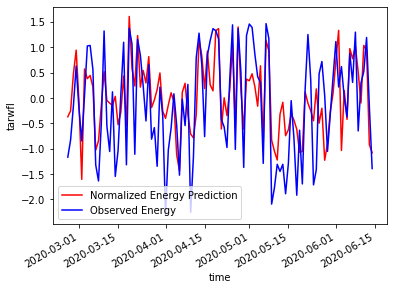

In [330]:
preds = model.predict(x_test)
preds1 = y_test.copy()
preds1.values = preds.ravel()
fig, ax = plt.subplots()
preds1.plot(ax = ax, color ='r', label ='Normalized Energy Prediction')
y_test.plot(ax = ax, color='b', label ='Observed Energy')
ax.legend()


[[1.         0.70722776]
 [0.70722776 1.        ]]


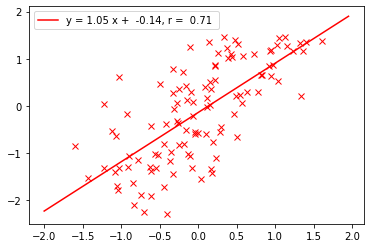

In [332]:
fig,ax = plt.subplots()
ax.plot(preds1.values, y_test.values,'rx')
f = linregress(preds1.values, y_test.values)
ax.plot(np.arange(-2,2,0.05), np.arange(-2,2,0.05)*f.slope + f.intercept,
        label =f'y = {"%.2f" % f.slope} x +  {"%.2f" % f.intercept}, r =  {"%.2f" % f.rvalue} ',
       color ='r')
ax.legend()
print(np.corrcoef(preds.ravel(),y_test.values
                 ))

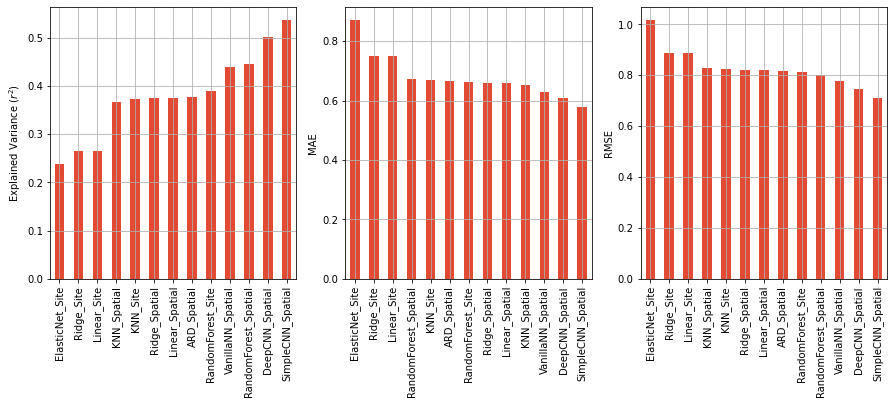

In [355]:

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
with plt.style.context('ggplot'):
    bar = (metrics['corrcoef']**2).sort_values().plot.bar(ax = ax[0])
    ax[0].set_ylabel('Explained Variance ($r^2$)')
    ax[1].set_ylabel('MAE')
    ax[2].set_ylabel('RMSE')
    metrics['mae'].sort_values(ascending = False).plot.bar(ax = ax[1])
    metrics['rmse'].sort_values(ascending = False).plot.bar(ax = ax[2])

In [352]:
bars.ax

<AxesSubplot:>